Создание и обучение модели было сделано на фреймворке PyTorch.

<h1>Подготовка датасета</h1>

Для использования предоставленных файлов, я создам класс для датасета, который по индексу будет выдавать тренировочные семплы.

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from tqdm import tqdm

class MovieDataSet(Dataset):
    def __init__(self):
        self.users = pd.read_csv("data/users_df.csv")
        self.items = pd.read_csv("data/items_df.csv")
        self.items = self.items.rename(columns={"id": "movie_id"})
        self.items["movie_id"] = self.items["movie_id"].astype(int)
        self.views = pd.read_csv("data/train_data.csv")
        self.views = self.views[self.views["duration"] >60]
        self.views["duration"][self.views["duration"] > 7200] = 7200
        self.views = self.views.set_index("user_id",drop=False)
        self.views = self.views.sort_index()
        self.users= self.users[self.users["user_id"].apply(lambda x: x in self.views["user_id"])]# удалить тех пользователей, у которые не смотрели ни один фильм дольше одной минуты
        views_count = self.views.value_counts("movie_id").to_frame()
        views_count = views_count.reset_index("movie_id")

        users_count = self.views.reset_index(drop=True).value_counts("user_id").to_frame() # удалить тех пользователей, у которых всего лишь один просмотренный фильма
        users_count = users_count[users_count["count"] > 1]
        users_count = users_count.reset_index("user_id")
        
        self.users = pd.merge(self.users,users_count,how="inner",on = ["user_id"])
        self.items = pd.merge(self.items,views_count,how="inner",on = ["movie_id"])
        

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user =self.users.iloc[[idx]]
        views = self.views.loc[[user["user_id"].iloc[0]]]

        min_rand = max(min(10,len(views)-3),1)
        max_rand =len(views)-1
        length = random.randint(min_rand,max_rand) # Аугментация, для каждого пользователя будет выбрана случайная длина его истории
        example = None # Выбор негатовного или позитивного семпла
        y = random.choice([-1,-1,1]) # на каждую позитивную метку приходтся две негативной
        if y == -1:
            while True:
                example = self.views.sample(1)
                if example["movie_id"].item() not in views["movie_id"].tolist():
                    break
        else:
            example = views.iloc[[length]]

        example = self.items[self.items["movie_id"] == example["movie_id"].iloc[0]]

        return user,views, example, torch.tensor([y]) # Пользователь, его история, пример для обучения, негативная или позитивная метка

<h1>Описание метода</h1>

Для решения данной задачи я решил использовать двухбашенную нейронной сеть, для генерации векторов встраиваний для пользователя и фильма, после чего рекомендация производилась на основе косинусного расстояния между векторами (CosineSimilarity).

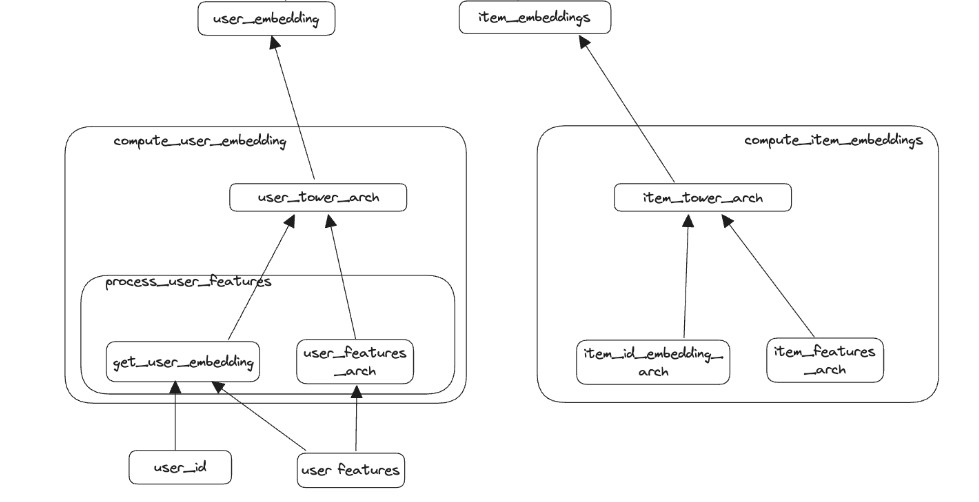

    - При обучении использовалась случайная негативная выборка.
    - Для позитивной выборки история пользователя имела случайную длину N, а положительный пример брался из N+1.
    - В качестве функции ошибки использовалась встроенная CosineSimilarityLoss.
    - Были исключены все пользователи, у которых всего лишь один просмотренный фильм.


Теперь необходимо закодировать все категориальные переменные, а так же ключевые слова, кастинг и страны. Для этого будут использоваться стандартные бинаризаторы из sklearn.

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder,LabelBinarizer

users = pd.read_csv("data/users_df.csv")
items = pd.read_csv("data/items_df.csv")
items = items.rename(columns={"id":"movie_id"})


train_data = pd.read_csv("data/train_data.csv")

# ЖАНРЫ
items["genres"] = items["genres"].apply(lambda x: eval(x))

genres = pd.read_csv("data/genres.csv")
genre_exp = items.explode("genres")
genre_counts = genre_exp["genres"].value_counts().to_frame()

genre_counts = genre_counts[genre_counts["count"] >=10]
genre_counts.insert(loc=0,column="h",value=genre_counts.index)

items["genres"] = items["genres"].apply(lambda x: [i for i in x if i in genre_counts["h"]])

genre_counts = items["genres"].values.tolist()

genre_binarizer = MultiLabelBinarizer()
genre_binarizer.fit(genre_counts)


# КЛЮЧЕВЫЕ СЛОВА

items["keywords"] = items["keywords"].replace(np.nan,"NaN").apply(lambda x: x.split(",")).apply(lambda x: [i.strip().lower() for i in x])

keywords_exp = items.explode("keywords")
keywords_counts = keywords_exp["keywords"].value_counts().to_frame()
keywords_counts = keywords_counts[keywords_counts["count"] >10]
keywords_counts.insert(loc=0,column="h",value=keywords_counts.index)

items["keywords"] = items["keywords"].apply(lambda x: [i for i in x if i in keywords_counts["h"]])
keywords_list = items["keywords"].values.tolist()

keywords_binarizer = MultiLabelBinarizer()
keywords_binarizer.fit(keywords_list)


# Персонал

items["staff"] = items["staff"].apply(lambda x: eval(x))

staff_exp = items.explode("staff")
staff_counts = staff_exp["staff"].value_counts().to_frame()

staff_counts = staff_counts[staff_counts["count"] >5]
staff_counts.insert(loc=0,column="h",value=staff_counts.index)

items["staff"] = items["staff"].apply(lambda x: [i for i in x if i in staff_counts["h"]])

staff_counts = items["staff"].values.tolist()

staff_binarizer = MultiLabelBinarizer()
staff_binarizer.fit(staff_counts)


#Страны

items["countries"] = items["countries"].apply(lambda x: eval(x))

countries_exp = items.explode("countries")
countries_counts = countries_exp["countries"].value_counts().to_frame()

countries_counts = countries_counts[countries_counts["count"] >=10]
countries_counts.insert(loc=0,column="h",value=countries_counts.index)

items["countries"] = items["countries"].apply(lambda x: [i for i in x if i in countries_counts["h"]])

countries_counts = items["countries"].values.tolist()

countries_binarizer = MultiLabelBinarizer()
countries_binarizer.fit(countries_counts)

#Возрастные категории

age_encoder = MultiLabelBinarizer()
age_encoder.fit(users["age_category"].replace(np.nan, "NaN").values.reshape(-1,1).tolist())

#Доход

income_encoder = MultiLabelBinarizer()
income_encoder.fit(users["income"].replace(np.nan, "NaN").values.reshape(-1,1).tolist())

#Пол
sex_encoder = MultiLabelBinarizer()
sex_encoder.fit(users["sex"].replace(np.nan, "NaN").values.reshape(-1,1).tolist())

#Образование
education_encoder = MultiLabelBinarizer()
education_encoder.fit(users["education"].replace(np.nan, "NaN").values.reshape(-1,1).tolist())


users = pd.read_csv("data/users_df.csv")
items = pd.read_csv("data/items_df.csv")
items = items.rename(columns={"id":"movie_id"})
train_data = pd.read_csv("data/train_data.csv")

views_count = train_data.value_counts("movie_id").to_frame()/17000
views_count = views_count.reset_index("movie_id")
items = pd.merge(items,views_count,how="inner",on = ["movie_id"])

<h1>Модели</h1>

Далее объявим классы для наших моделей. Для обучения встраиваний пользователя и фильма будет использована обычная полносвязная сеть с нормализацией слоя и LeakyReLU. Модель пользователя так же будет дополнена рекуррентной нейронной сетью для анализа истории просмотров. 

In [3]:
class UserEmbedding(torch.nn.Module):
    def __init__(self,embed_dim = 128):
        super(UserEmbedding,self).__init__()

        self.input_dim = 6 + 5 + 3 + 1 + 5
        self.rnn = torch.nn.LSTM(embed_dim+1,3*embed_dim,bidirectional=True, batch_first=True)
        self.feedforward = torch.nn.Sequential(torch.nn.Linear(self.input_dim + 6*embed_dim, 2*embed_dim),
                                               torch.nn.LayerNorm(2*embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(2*embed_dim, 2*embed_dim),
                                               torch.nn.LayerNorm(2 * embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(2 * embed_dim, 2 * embed_dim),
                                               torch.nn.LayerNorm(2 * embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(2 * embed_dim, embed_dim)
        )

    def sequence_emb(self,x):
        item_embs = self.rnn(x) #?
        return item_embs
    def forward(self,x):

        x = self.feedforward(x)

        return x

class ItemEmbedding(torch.nn.Module):
    def __init__(self,embed_dim = 128):
        super(ItemEmbedding,self).__init__()

        self.input_dim = 2 + 58 + 2305 + 1947 + 42 # признаки: дата, жанр, ключевые слова, режиссеры и актеры, страны

        self.feedforward = torch.nn.Sequential(torch.nn.Linear(self.input_dim, 2*embed_dim),
                                               torch.nn.LayerNorm(2*embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(2*embed_dim, embed_dim),
                                               torch.nn.LayerNorm(embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(embed_dim, embed_dim),
                                               torch.nn.LayerNorm(embed_dim),
                                               torch.nn.LeakyReLU(0.2),
                                               torch.nn.Linear(embed_dim, embed_dim))
    def forward(self,x):
        x = self.feedforward(x)

        return x


Далее объявим класс рекомендательной системы, которая совместит работу двух моделей, а также будет обрабатывать данные для подачи на вход нейронной сети. 

In [4]:
class RecSys:
    def __init__(self,embed_dim = 128,device = torch.device("cpu")):
        self.user_model = UserEmbedding(embed_dim)
        self.item_model = ItemEmbedding(embed_dim)
        self.device = device
        self.user_model.to(device)
        self.item_model.to(device)


    def get_user_embedding(self,records,views): # На вход подается DataFrame пользователей и список с DataFrame просмотром соответствующего пользователя.
        users_and_items_emb = []
        for i in range(len(records["user_id"])): # Кодирование истории просмотра пользователя
            items_for_user= pd.merge(views[i],items,how="inner", on=["movie_id"])
            movies_emb_seq = self.get_item_embedding(items_for_user).to(self.device)
            duration = (torch.tensor(items_for_user["duration"].values,dtype=torch.float32,device=self.device))/7200 #кодирование времени просмотра
            movies_emb_seq = torch.concat([movies_emb_seq,duration.unsqueeze(-1)],dim=-1)
            users_and_items_emb.append(self.user_model.sequence_emb(movies_emb_seq)[1][0].reshape(1,-1))
        

        #Кодирование остальных признаков пользователя
        l = records["age_category"].values.reshape(-1,1)
        age = torch.tensor(age_encoder.transform(records["age_category"].replace(np.nan, "NaN").values.reshape(-1,1)),device=self.device)
        income = torch.tensor(income_encoder.transform(records["income"].replace(np.nan, "NaN").values.reshape(-1,1)),device=self.device)
        sex = torch.tensor(sex_encoder.transform(records["sex"].replace(np.nan, "NaN").values.reshape(-1,1)),device=self.device)
        kids = torch.tensor(records["kids_flg"].replace(np.nan,0).values.reshape(-1,1),device=self.device)
        education = torch.tensor(education_encoder.transform(records["education"].replace(np.nan, "NaN").values.reshape(-1,1)),device=self.device)
        users_and_items_emb = torch.concatenate(users_and_items_emb,dim=0)

        features = torch.concatenate([age,income,sex,kids,education,users_and_items_emb],dim=-1).to(self.device,torch.float32)

        return self.user_model(features)

    def get_item_embedding(self,records):

        # обработка данных фильма
        date = pd.to_datetime(records["year"]).dt.year - 2025
        date = np.abs(date)
        date = torch.tensor(np.emath.logn(100,date.values))

        genres = records["genres"].apply(lambda x: eval(x))
        genres = torch.tensor(genre_binarizer.transform(genres.values.tolist()))

        keywords = records["keywords"].replace(np.nan, "NaN").apply(lambda x: x.split(",")).apply(lambda x: [i.strip().lower() for i in x])
        keywords = keywords.apply(lambda x: [i for i in x if i in keywords_counts["h"]])
        keywords = torch.tensor(keywords_binarizer.transform(keywords.values.tolist()))

        staff = records["staff"].apply(lambda x: eval(x))
        staff = torch.tensor(staff_binarizer.transform(staff.values.tolist()))

        countries = records["countries"].apply(lambda x: eval(x))
        countries = torch.tensor(countries_binarizer.transform(countries.values.tolist()))

        popularity = torch.tensor(records["count"].values).unsqueeze(-1)/17000

        features = torch.concatenate([date.unsqueeze(-1),genres,keywords,staff,countries,popularity],dim=-1).to(self.device,torch.float32)

        embedding = self.item_model(features)

        return embedding

    def save(self):
        torch.save(self.user_model.state_dict(), "user_model")
        torch.save(self.item_model.state_dict(), "item_model")

    def load(self): 
        self.user_model.load_state_dict(torch.load("user_model"))
        self.item_model.load_state_dict(torch.load("item_model"))


Далее напишем код для обучения данной модели. 

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from model import *
from dataset import MovieDataSet
def custom_collate(batch):
    users = pd.concat(list(map(lambda x:x[0],batch)))
    views = list(map(lambda x:x[1],batch))
    example = pd.concat(list(map(lambda x:x[2],batch)))
    y = torch.concat(list(map(lambda x:x[3],batch)))

    return users,views,example,y

EPOCHES_COUNT = 0
BATCH_SIZE = 128

model = RecSys(embed_dim=64,device=torch.device("cuda"))
#model.load()

dataset = MovieDataSet()
dataloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,collate_fn=custom_collate,shuffle=True)

optimizer = torch.optim.Adam(list(model.user_model.parameters()) + list(model.item_model.parameters()),lr = 0.001)
torch.autograd.set_detect_anomaly(True)

dataset = None

criterion = torch.nn.CosineEmbeddingLoss(reduction="mean",margin=0)

for epoch in range(EPOCHES_COUNT):
    print("Epoch:", epoch + 1)
    it = iter(dataloader)
    sr = 0
    t = tqdm(range(len(dataloader)))
    for i in t:
        user_batch, views_batch, items_batch, targets = next(it)

        users_emb = model.get_user_embedding(user_batch,views_batch)
        items_emb = model.get_item_embedding(items_batch)
        targets = targets.to(model.device)


        #k = torch.nn.CosineEmbeddingLoss(reduction="none",margin=0)(users_emb,items_emb,targets)
        loss = criterion(users_emb,items_emb,targets)# + 0.01*(users_emb.mean() + items_emb.mean())**2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sr += float(loss) / len(dataloader)
        t.set_postfix_str("loss= {}".format(float(loss)))
    print("LOSS:",sr)
#model.save()


После этого обе модели для пользователей и для фильмов будут сохранены в рабочую папку.

<h1>Валидация</h1>

Для валидации будет взят класс из baseline блокнота.


In [6]:
from abc import ABC, abstractmethod

class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame,views):
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass


class DSSMRecommender(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.model = RecSys(embed_dim=64,device=torch.device("cpu"))
        self.model.load()
    def fit(self, df: pd.DataFrame) -> None:
        pass
    def load(self,items): # Вычисление и сохранение эмбеддингов фильмов
        self.item_embeds = {}
        embeds = self.model.get_item_embedding(items)
        for i in tqdm(range(len((items)))):
            self.item_embeds[items.iloc[i]["movie_id"].item()] = embeds[i]
    def find_sim(self,user,views): # Для одного пользователя
        user_emb = self.model.get_user_embedding(user,views)

        ranking = []

        for i in self.item_embeds:
            sim = torch.nn.functional.cosine_similarity(user_emb, self.item_embeds[i].unsqueeze(0))
            ranking.append([i, sim.item()])

        ranking.sort(key=lambda x: x[1],reverse=True)

        return list(map(lambda x : x[0],ranking[:10]))
    def predict(self, df, views):
        result =[]
        views = views.set_index("user_id", drop=False)
        views = views.sort_index()
        for i in tqdm(range(len(df))[:400]):
            only_views = [views.loc[[df.iloc[i]["user_id"].item()]].sort_values("datetime")]
            predicts = self.find_sim(df.iloc[[i]],only_views)
            result.append(predicts)
        return result


Валидация всего тестового датасета может занять длительное время. 
Для начала вычислим эмбеддинги всех фильмов в датасете.

In [7]:
recommender = DSSMRecommender()

movies = pd.read_csv("data/items_df.csv")
movies = movies.rename(columns={"id":"movie_id"})

views = pd.read_csv("data/train_data.csv")
views_count = views.value_counts("movie_id").to_frame()
views_count = views_count.reset_index("movie_id")
movies = pd.merge(movies,views_count,how="inner",on = ["movie_id"])

recommender.load(movies)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5269/5269 [00:01<00:00, 3406.88it/s]


После чего загружаем всех пользователей и их истории просмотров. И запускаем валидацию. Поскольку тестовых выборок около 4 млн, а более оптимизированный поиск наиболее похожих векторов, кроме как полного перебора, я реализовать не успел, то обработка тестовой выборки займет несколько часов.

In [8]:
users = pd.read_csv("data/users_df.csv")
test_data = pd.read_csv("data/test_data.csv")[:400]
test_data = test_data.groupby("user_id").agg({"movie_id": list}).reset_index()

test_data = pd.merge(test_data,users,how="inner",on=["user_id"])
with torch.no_grad(): #ty
    test_data["preds"] = recommender.predict(test_data,views)

test_data.to_csv("test_evaluations.csv")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:31<00:00, 12.03it/s]


Файл с результатами теста сохранен в рабочую папку, в третьем блокноте будет проведен анализ результатов.